In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import matplotlib
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append('/home/sima9999/git/pyOMA')

from pyOMA.core.PreProcessingTools import PreProcessSignals, GeometryProcessor, SignalPlot
from pyOMA.core.StabilDiagram import StabilCalc, StabilCluster, StabilPlot
from pyOMA.core.PostProcessingTools import MergePoSER
from pyOMA.core.PlotMSH import ModeShapePlot

from pyOMA.GUI.JupyterGUI import PlotMSHWeb, StabilGUIWeb, SnappingCursor, OutputWidgetHandler, ConfigGUIWeb

In [3]:
project_dir = Path('/home/sima9999/git/pyOMA/tests/files/')
nodes_file = project_dir / 'grid.txt'
lines_file = project_dir / 'lines.txt'
parent_child_file = ''

meas_name = 'measurement_1'
setup_dir = project_dir / meas_name
result_dir = setup_dir

setup_info_file = setup_dir / 'setup_info.txt'
meas_file = setup_dir / (meas_name + '.npy')
oma_conf_file = project_dir / 'varssi_config.txt'
chan_dofs_file = setup_dir / "channel_dofs.txt"

skip_existing=True
save_results=False



In [4]:
display(ConfigGUIWeb(locals()))

In [5]:
geometry_data = GeometryProcessor.load_geometry(
    nodes_file=nodes_file,
    lines_file=lines_file,
    parent_childs_file=parent_child_file)

In [6]:
PreProcessSignals.load_measurement_file = np.load
if not os.path.exists(setup_dir / 
        'prep_signals.npz') or not skip_existing:
    prep_signals = PreProcessSignals.init_from_config(
        conf_file=setup_info_file,
        meas_file=meas_file,
        chan_dofs_file=chan_dofs_file)
    prep_signals.load_measurement_file = np.load
    if save_results:
        prep_signals.save_state(result_dir / 'prep_signals.npz')
else:
    prep_signals = PreProcessSignals.load_state(result_dir / 'prep_signals.npz')
    
prep_signals.decimate_signals(8)

INFO:pyOMA.core.PreProcessingTools:Loading results from  /home/sima9999/git/pyOMA/tests/files/measurement_1/prep_signals.npz
INFO:pyOMA.core.PreProcessingTools:Decimating signals by factor 8 to a sampling rate of 32.0 Hz
INFO:pyOMA.core.PreProcessingTools:Filtering signals in the band: None .. 12.8 with a 8 order cheby1 filter.


In [15]:
modal_data = method.init_from_config(oma_conf_file, prep_signals)

INFO:pyOMA.core.VarSSIRef:Building subspace matrices with covariance-based method...
INFO:pyOMA.core.VarSSIRef:Assembling 50 Hankel matrices using pre-computed correlation functions 70 block-columns and 71 block rows 
INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with m_lags=141 and n_segments=50...
....................................................................................................
INFO:pyOMA.core.VarSSIRef:Computing state matrices with pinv-based method...
INFO:pyOMA.core.VarSSIRef:Preparing sensitivities for use with fast (co)variance algorithm...
....................................................................................................
INFO:pyOMA.core.VarSSIRef:Computing modal parameters with fast (co)variance computation...
..................................................................................................

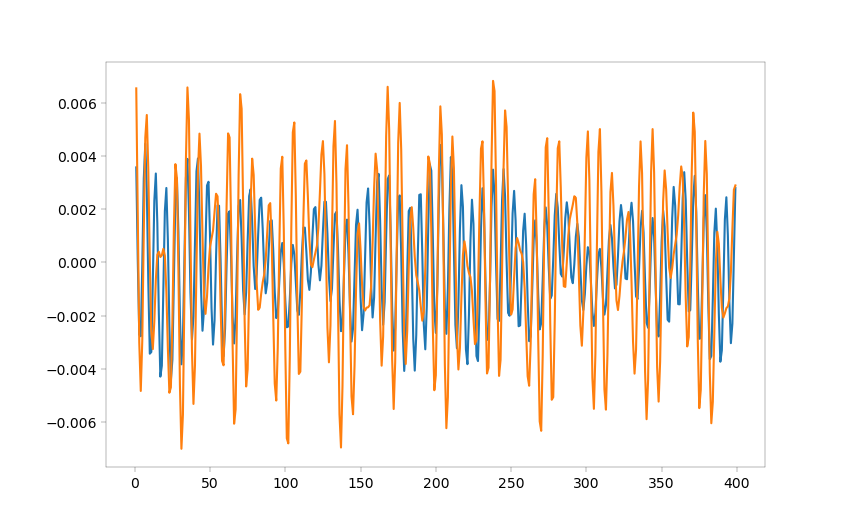

INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with m_lags=401 and n_segments=30...
....................................................................................................


In [18]:
'''

in VarSSIRef correlation estimates are accidentally dived by num_analised_channels, instead of N_block (dimensions of matrix reversed)
in PreProcessSignals the correlation estimate is normalized by ''N_block - m'' (standard unbiased estimator) exagerating function values towards higher lag values

'''

plt.close('all')
prep_signals.corr_matrix_bt = None
modal_data.plot_covariances()
prep_signals.corr_blackman_tukey(401,num_blocks=30)
for block in range(30):
    # plt.figure()
    for ref_index, ref_number in enumerate(prep_signals.ref_channels):
        plt.plot(range(1, 401), prep_signals.corr_matrices_bt[block, ref_number,ref_index,1:401] * 30)#*(np.floor(prep_signals.total_time_steps/30) * prep_signals.num_analised_channels/0.83*.993765822
    break

In [16]:
stabil_calc = StabilCalc(modal_data)
stabil_plot = StabilPlot(stabil_calc)

In [17]:
vbox, snap_cursor =StabilGUIWeb(stabil_plot)
display(vbox)

INFO:pyOMA.core.StabilDiagram:Checking stabilisation criteria...
....................................................................................................
